# GloVE

Let's work on implementation of GloVE.
- based on the co-occurences

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt


## 1. Load Data

### 1.1 word segmentation

In [2]:
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple", 
          "dog cat animal", "cat animal dog", "cat dog animal"]

In [3]:
corpus = [sent.split(" ") for sent in corpus]
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'animal', 'dog'],
 ['cat', 'dog', 'animal']]

### 1.2 numericalization

In [4]:
# get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))

In [5]:
vocab

['banana', 'cat', 'fruit', 'animal', 'apple', 'dog']

In [6]:
# type(set(flatten(corpus)))
# type(vocab)

In [7]:
# numericalization
word2index = {w:idx for idx,w in enumerate(vocab)}
print(word2index)

{'banana': 0, 'cat': 1, 'fruit': 2, 'animal': 3, 'apple': 4, 'dog': 5}


In [8]:
# vocab size
voc_size = len(vocab)
print(voc_size)

6


In [9]:
# append UNK
vocab.append("<UNK>")
word2index['<UNK>'] = 6

In [10]:
word2index

{'banana': 0,
 'cat': 1,
 'fruit': 2,
 'animal': 3,
 'apple': 4,
 'dog': 5,
 '<UNK>': 6}

In [11]:
# index to word dict array, just in case we need to use
index2word = {v:k for k,v in word2index.items()}

## 2. Build Co-occurence Matrix X

Here we need to count the co-occurence of two words given some window size. We gonna use window size of 1.

In [12]:
from collections import Counter

X_i = Counter(flatten(corpus)) # find occurences of each word
X_i

Counter({'apple': 3, 'banana': 3, 'fruit': 3, 'dog': 3, 'cat': 3, 'animal': 3})

In [13]:
# find co-occurence

skip_grams = []

for doc in corpus:
    for i in range (1, len(doc)-1):
        center = doc[i]
        outside = [doc[i-1], doc[i+1]]
        
        for each_out in outside:
            skip_grams.append((center, each_out)) # tuple

In [14]:
skip_grams

[('banana', 'apple'),
 ('banana', 'fruit'),
 ('apple', 'banana'),
 ('apple', 'fruit'),
 ('fruit', 'banana'),
 ('fruit', 'apple'),
 ('cat', 'dog'),
 ('cat', 'animal'),
 ('animal', 'cat'),
 ('animal', 'dog'),
 ('dog', 'cat'),
 ('dog', 'animal')]

In [15]:
X_ik_skipgrams = Counter (skip_grams)
X_ik_skipgrams

Counter({('banana', 'apple'): 1,
         ('banana', 'fruit'): 1,
         ('apple', 'banana'): 1,
         ('apple', 'fruit'): 1,
         ('fruit', 'banana'): 1,
         ('fruit', 'apple'): 1,
         ('cat', 'dog'): 1,
         ('cat', 'animal'): 1,
         ('animal', 'cat'): 1,
         ('animal', 'dog'): 1,
         ('dog', 'cat'): 1,
         ('dog', 'animal'): 1})

### Weighting function

GloVe includes a weighting function to scale down too frequent words.


In [16]:
def weighting(w_i, w_j, X_ik):
    
    # check whether the co-occurences between two words: w_i and w_j is available
    try:
        x_ij = X_ik[(w_i, w_j)]
        
    # if not exist, then set to 1; "laplace smoothing"
    except:
        x_ij = 1
        
    # set xmax (xmax = the maximum count of co words we will accept)
    x_max = 100
    
    # set alpha (f(x))
    alpha = 0.75 
    
            # note all xmax and alpha number are using according to the paper glove
    
    # if co-occurences does not exceed xmax, then just multiply with some alpha
    if x_ij < x_max:
        result = (x_ij / x_max) ** alpha
    
    # otherwise set it to 1 (if xmax, set to 1)
    else:
        result = 1
    
    return result # return the number between 0 and 1 which is the weighting function

In [17]:
# co-occurences matrix

from itertools import combinations_with_replacement

# a dict for keeping the co-occurences
X_ik = {}

# already scale the co-occurences using the weighting function
weighting_dic = {}

for bigram in combinations_with_replacement(vocab, 2):
    
    # give all the possible combination of the words
    print(bigram) 
    
    # if the pair exists in out corpus
    if X_ik_skipgrams.get(bigram):
        co                           = X_ik_skipgrams[bigram]
        X_ik[bigram]                 = co + 1 # for stability, (if no occurence we set 1, so if occurences we need to plus 1)
        X_ik[(bigram[1], bigram[0])] = co + 1 # basically (apple, banana = banana, apple)
    else:
        pass
    
    weighting_dic[bigram]                 = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

('banana', 'banana')
('banana', 'cat')
('banana', 'fruit')
('banana', 'animal')
('banana', 'apple')
('banana', 'dog')
('banana', '<UNK>')
('cat', 'cat')
('cat', 'fruit')
('cat', 'animal')
('cat', 'apple')
('cat', 'dog')
('cat', '<UNK>')
('fruit', 'fruit')
('fruit', 'animal')
('fruit', 'apple')
('fruit', 'dog')
('fruit', '<UNK>')
('animal', 'animal')
('animal', 'apple')
('animal', 'dog')
('animal', '<UNK>')
('apple', 'apple')
('apple', 'dog')
('apple', '<UNK>')
('dog', 'dog')
('dog', '<UNK>')
('<UNK>', '<UNK>')


In [18]:
X_ik

{('banana', 'fruit'): 2,
 ('fruit', 'banana'): 2,
 ('banana', 'apple'): 2,
 ('apple', 'banana'): 2,
 ('cat', 'animal'): 2,
 ('animal', 'cat'): 2,
 ('cat', 'dog'): 2,
 ('dog', 'cat'): 2,
 ('fruit', 'apple'): 2,
 ('apple', 'fruit'): 2,
 ('animal', 'dog'): 2,
 ('dog', 'animal'): 2}

In [19]:
weighting_dic

{('banana', 'banana'): 0.03162277660168379,
 ('banana', 'cat'): 0.03162277660168379,
 ('cat', 'banana'): 0.03162277660168379,
 ('banana', 'fruit'): 0.053182958969449884,
 ('fruit', 'banana'): 0.053182958969449884,
 ('banana', 'animal'): 0.03162277660168379,
 ('animal', 'banana'): 0.03162277660168379,
 ('banana', 'apple'): 0.053182958969449884,
 ('apple', 'banana'): 0.053182958969449884,
 ('banana', 'dog'): 0.03162277660168379,
 ('dog', 'banana'): 0.03162277660168379,
 ('banana', '<UNK>'): 0.03162277660168379,
 ('<UNK>', 'banana'): 0.03162277660168379,
 ('cat', 'cat'): 0.03162277660168379,
 ('cat', 'fruit'): 0.03162277660168379,
 ('fruit', 'cat'): 0.03162277660168379,
 ('cat', 'animal'): 0.053182958969449884,
 ('animal', 'cat'): 0.053182958969449884,
 ('cat', 'apple'): 0.03162277660168379,
 ('apple', 'cat'): 0.03162277660168379,
 ('cat', 'dog'): 0.053182958969449884,
 ('dog', 'cat'): 0.053182958969449884,
 ('cat', '<UNK>'): 0.03162277660168379,
 ('<UNK>', 'cat'): 0.03162277660168379,
 (

## 3. Prepare train data

In [20]:
import math

In [21]:
skip_grams

[('banana', 'apple'),
 ('banana', 'fruit'),
 ('apple', 'banana'),
 ('apple', 'fruit'),
 ('fruit', 'banana'),
 ('fruit', 'apple'),
 ('cat', 'dog'),
 ('cat', 'animal'),
 ('animal', 'cat'),
 ('animal', 'dog'),
 ('dog', 'cat'),
 ('dog', 'animal')]

In [22]:
def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    random_inputs, random_labels, random_coos, random_weightings = [], [], [], []
    
    # convert our skipgrams to id using word2index
    skip_grams_id = [(word2index[skipgram[0]], word2index[skipgram[1]]) for skipgram in skip_grams]
    # print(skip_grams_id)
    
    # randomly choose indexes based on batch_size
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace = False)
    
    # get the random input and labels
    for index in random_index:
        random_inputs.append([skip_grams_id[index][0]]) # center word, x
        random_labels.append([skip_grams_id[index][1]]) # outside word, y
    
        # co occerences
        pair = skip_grams[index] #('banana','fruit')
        
        try:
            cooc = X_ik[pair]   
        except:
            cooc = 1
            
        random_coos.append([math.log(cooc)])
    
        # weightings
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
            
    return np.array(random_inputs), np.array(random_labels), np.array(random_coos), np.array(random_weightings)

#### test

In [23]:
batch_size = 2
x, y, cooc, weighting = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

In [24]:
x # center word

array([[5],
       [0]])

In [25]:
y # outside word

array([[3],
       [2]])

In [26]:
index2word[0], index2word[4]

('banana', 'apple')

In [27]:
index2word[1], index2word[2]

('cat', 'fruit')

In [28]:
cooc #co-occurences

array([[0.69314718],
       [0.69314718]])

In [29]:
weighting 

array([[0.05318296],
       [0.05318296]])

## 4. Model

loss funciton:

$$ J = \sum_{i,j=1}^{V} (f(X_{ij})) (w_{i}^{T}w_{j} + b_{i} + b_{j} - \log X_{ij})^{2}

In [30]:
class Glove(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        self.center_embedding  = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)
        
        self.center_bias       = nn.Embedding(voc_size, 1)
        self.outside_bias      = nn.Embedding(voc_size, 1) 
        
    def forward(self, center, outside, cooc, weighting):
        center_embeds  = self.center_embedding(center)   # (batch_size, 1, embed_size)
        outside_embeds = self.outside_embedding(outside) # (batch_size, 1, embed_size)
        
        center_bias    = self.center_bias(center).squeeze(1) # (batch_size, voc_size)
        target_bias    = self.outside_bias(outside).squeeze(1)
        
        inner_product = outside_embeds.bmm(center_embeds.transpose(1,2)).squeeze(2)
        # (batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)
        
        loss = weighting * torch.pow(inner_product + center_bias + target_bias - cooc, 2)
        
        return torch.sum(loss)

In [31]:
# test out system

voc_size   = len(vocab)
emb_size = 2
model = Glove(voc_size, emb_size)

In [32]:
#convert numpy array to Tensor

x_tensor         = torch.LongTensor(x)
y_tensor         = torch.LongTensor(y)
cooc_tensor      = torch.FloatTensor(cooc)
weighting_tensor = torch.FloatTensor(weighting)

In [33]:
loss = model(x_tensor, y_tensor,  cooc_tensor, weighting_tensor)

In [34]:
loss

tensor(0.0863, grad_fn=<SumBackward0>)

## 5. Training

In [36]:
batch_size     = 10 # mini-batch size
embedding_size = 2 # so we can later plot

model          = Glove(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [38]:
# time estimation
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
import time

# Training

num_epochs = 5000

for epoch in range(num_epochs):
    
    # record the starting time for each epoch
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch     = torch.LongTensor(input_batch) #[batch_size, 1]
    target_batch    = torch.LongTensor(target_batch) #[batch_size, 1]
    cooc_batch      = torch.FloatTensor(cooc_batch) #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()
    
    # record the ending time for each epoch
    end = time.time()
    
    # cal training time for each epoch
    epoch_mins, epoch_secs = epoch_time(start,end)
    
    if(epoch+1) % 1000 == 0:
        print(f"Epoch: {epoch+1:6.0f} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")
    

Epoch:   1000 | cost: 0.000000 | time: 0m 0s
Epoch:   2000 | cost: 0.000000 | time: 0m 0s
Epoch:   3000 | cost: 0.000000 | time: 0m 0s
Epoch:   4000 | cost: 0.000000 | time: 0m 0s
Epoch:   5000 | cost: 0.000000 | time: 0m 0s


## 6. Plotting the embeddings

In [41]:
# list of vocabs
vocab[:10]

['banana', 'cat', 'fruit', 'animal', 'apple', 'dog', '<UNK>']

In [43]:
word = vocab[0]
word

'banana'

In [44]:
# numericalization
id = word2index[word]
id

0

In [46]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [47]:
# get the embedding by averaging
v_embed = model.center_embedding(id_tensor)
u_embed = model.outside_embedding(id_tensor)

v_embed, u_embed

(tensor([[1.0354, 0.0588]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 1.4599, -0.6691]], grad_fn=<EmbeddingBackward0>))

In [48]:
# average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed 

tensor([[ 1.2477, -0.3052]], grad_fn=<DivBackward0>)

In [49]:
word_embed[0][1]

tensor(-0.3052, grad_fn=<SelectBackward0>)

In [50]:
# let's write a function to get embedding given a word
def get_embed(word):
    id_tensor  = torch.LongTensor([word2index[word]])
    v_embed    = model.center_embedding(id_tensor)
    u_embed    = model.outside_embedding(id_tensor)
    word_embed = (v_embed + u_embed) / 2
    x, y       = word_embed[0][0].item(), word_embed[0][1].item()
    
    return x,y

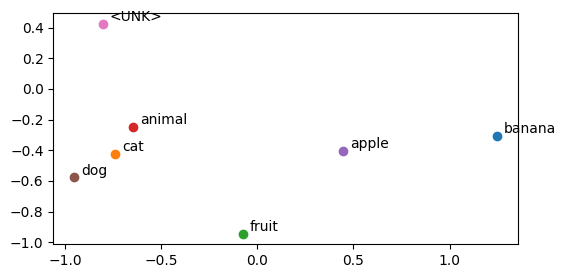

In [51]:
# plot the point

plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): # loop each unique vocab
    x,y = get_embed(word)
    plt.scatter(x,y)
    plt.annotate(word, xy = (x,y), xytext=(5,2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

Formally the Cosine Similarity s between two vectors p and q is defined as:

$$ s = \frac {p.q} {||p|| ||q|| }, where \space s \in [-1,1] $$

if p and q is super similar, the result is 1. Otherwise, 0.

In [54]:
vocab

['banana', 'cat', 'fruit', 'animal', 'apple', 'dog', '<UNK>']

In [55]:
# let's try similarity between first and second, and second and third

cat    = get_embed('cat')
fruit  = get_embed('fruit')
animal = get_embed('animal')

In [56]:
# numpy version

from numpy import dot
from numpy.linalg import norm

def cos_sim(a,b):
    cos_sim = dot(a,b) / (norm(a) * norm(b))
    return cos_sim

print(f"cat vs. fruit: ", cos_sim(cat,fruit))
print(f"cat vs. animal: ", cos_sim(cat,animal))
print(f"cat vs. cat: ", cos_sim(cat,cat))

cat vs. fruit:  0.5621693913348489
cat vs. animal:  0.9880440631499581
cat vs. cat:  1.0


In [57]:
# spicy version

from scipy import spatial

def cos_sim(a,b):
    cos_sim = 1 - spatial.distance.cosine(a,b) 
    # distance = 1 - similarity , because scipy only gives distances
    return cos_sim

print(f"cat vs. fruit: ", cos_sim(cat,fruit))
print(f"cat vs. animal: ", cos_sim(cat,animal))
print(f"cat vs. cat: ", cos_sim(cat,cat))

cat vs. fruit:  0.562169391334849
cat vs. animal:  0.9880440631499582
cat vs. cat:  1
